In [6]:
import os
import numpy as np
import cv2
import torch
from skimage.segmentation import slic
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import datetime
import matplotlib.pyplot as plt
from torchvision import transforms

time = str(datetime.datetime.now()).split(" ")[0]

In [7]:
# Constants
NUM_CLASSES = 5  # Adjust based on the number of roof material types
DEVICE = torch.device("cpu")
SATELLITE_FOLDER = "./images/satellites"
MASK_FOLDER = "./images/masks"
MODEL_PATH = "./gcn_roof_model.pth"

# Hyperparameter
epoch_num = 100


In [8]:

# GCN Model Definition
class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index)
        return x

def preprocess_data(image_path, mask_path, flipp):
    image = cv2.imread(image_path)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)  # Load as grayscale for single-channel labels
    if flipp == 1:
        image = cv2.flip(image, 1)
        mask = cv2.flip(mask, 1)
    
    # Replace grayscale values with new labels
    mask[mask == 255] = 0
    mask[mask == 179] = 1
    mask[mask == 131] = 2
    mask[mask == 150] = 3
    mask[mask == 222] = 4

    # Segment satellite image into superpixels
    segments = slic(image, n_segments=100, compactness=10, start_label=1)

    # Generate node features (average color of each superpixel) and labels
    node_features = []
    node_labels = []
    unique_segments = np.unique(segments)

    for segment in unique_segments:
        mask_segment = segments == segment
        avg_color = image[mask_segment].mean(axis=0)
        node_features.append(avg_color)

        # Majority vote for label assignment
        segment_labels = mask[mask_segment]
        label = np.argmax(np.bincount(segment_labels))
        node_labels.append(label)
    
    # Convert to PyTorch tensors
    node_features = torch.tensor(np.array(node_features), dtype=torch.float32).to(DEVICE)
    node_labels = torch.tensor(np.array(node_labels), dtype=torch.long).to(DEVICE)
    
    # Generate simple edge connections (adjacent superpixels)
    edges = [[i, i + 1] for i in range(len(unique_segments) - 1)]
    edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous().to(DEVICE)

    # Create the graph data object and store segments for potential later use
    data = Data(x=node_features, edge_index=edge_index, y=node_labels)
    data.segments = segments  # Optional: useful if you want to map predictions back to the original image shape
    return data

# Load all images and masks into graphs
def load_dataset(satellite_folder, mask_folder):
    dataset = []
    satellite_images = sorted([f for f in os.listdir(satellite_folder) if f.lower().endswith('.png')])
    masks = sorted([f for f in os.listdir(mask_folder) if f.lower().endswith('.png')])

    for sat_image, mask_image in tqdm(zip(satellite_images, masks)):
        sat_path = os.path.join(satellite_folder, sat_image)
        mask_path = os.path.join(mask_folder, mask_image)
        graph_data = preprocess_data(sat_path, mask_path, flipp = 0)
        dataset.append(graph_data)
        graph_data = preprocess_data(sat_path, mask_path, flipp= 1)
        dataset.append(graph_data)
    return dataset

# Function to save model and training state
def save_checkpoint(model, optimizer, epoch, path):
    checkpoint = {
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'epoch': epoch
    }
    torch.save(checkpoint, path)
    print(f"Checkpoint saved at: {path}")

# Function to load model and training state
def load_checkpoint(path, model, optimizer):
    if os.path.exists(path):
        checkpoint = torch.load(path)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        start_epoch = checkpoint.get('epoch', 0)
        print(f"Checkpoint loaded from: {path}.")
        return model, optimizer, start_epoch
    else:
        print(f"No checkpoint found at: {path}. Starting from scratch.")
        return model, optimizer, 0

# Train the GCN with integrated validation evaluation and metric logging
def train_gcn(data_list):
    # Split into training and validation sets using the graphs from load_dataset
    train_data, val_data = train_test_split(data_list, test_size=0.2, random_state=42)

    # Define GCN model, optimizer, and loss criterion
    model = GCN(in_channels=3, hidden_channels=16, out_channels=NUM_CLASSES).to(DEVICE)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    weights = [0.5,1,1,1,1]
    class_weights = torch.tensor(weights).to(DEVICE)
    criterion = torch.nn.CrossEntropyLoss(weight=class_weights)

    # Load checkpoint if available
    model, optimizer, start_epoch = load_checkpoint(MODEL_PATH, model, optimizer)
    # Lists to record metrics
    train_losses = []
    val_losses = []
    val_accuracies = []
    
    # Training loop with metric logging
    for epoch in tqdm(range(start_epoch, epoch_num)):
        model.train()
        train_loss = 0
        for data in train_data:
            optimizer.zero_grad()
            out = model(data.x, data.edge_index)
            loss = criterion(out, data.y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        avg_train_loss = train_loss / len(train_data)
        train_losses.append(avg_train_loss)

        # Evaluate on validation data
        model.eval()
        val_loss = 0
        correct = 0
        total = 0
        with torch.no_grad():
            for data in val_data:
                out = model(data.x, data.edge_index)
                loss = criterion(out, data.y)
                val_loss += loss.item()
                preds = out.argmax(dim=1)
                correct += (preds == data.y).sum().item()
                total += data.y.size(0)
        avg_val_loss = val_loss / len(val_data)
        val_losses.append(avg_val_loss)
        val_accuracy = correct / total
        val_accuracies.append(val_accuracy)

        """print(f"Epoch {epoch + 1}, Train Loss: {avg_train_loss:.4f}, "
              f"Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")"""

    save_checkpoint(model, optimizer, epoch_num, MODEL_PATH)
    print("Training complete.")
    return model, val_data, train_losses, val_losses, val_accuracies


In [9]:
# Step 1: Load all images and masks as graphs
dataset = load_dataset(SATELLITE_FOLDER, MASK_FOLDER)
print(f"Loaded {len(dataset)} graphs.")


84it [00:42,  1.96it/s]


KeyboardInterrupt: 

In [ ]:

# Step 2: Train GCN with integrated validation evaluation and metric logging
trained_model, validation_data, train_losses, val_losses, val_accuracies = train_gcn(dataset)


NameError: name 'train_gcn' is not defined

In [ ]:

# Optional: Evaluate final validation accuracy
trained_model.eval()
correct = 0
total = 0
class_counts = np.zeros(NUM_CLASSES)  # To count detection for each class
class_correct = np.zeros(NUM_CLASSES)  # To count correct predictions per class

with torch.no_grad():
    for data in validation_data:
        out = trained_model(data.x, data.edge_index)
        preds = out.argmax(dim=1)
        
        # Update total and correct counts for accuracy
        correct += (preds == data.y).sum().item()
        total += data.y.size(0)

        # Update class detection counts
        for label in range(NUM_CLASSES):
            class_counts[label] += (preds == label).sum().item()
            class_correct[label] += ((preds == label) & (data.y == label)).sum().item()

final_val_accuracy = correct / total
print(f"Final Validation Accuracy: {final_val_accuracy:.4f}")

# Print the class detection counts and the correct detection rate per class
print("Class-wise detection count (how many times each class was predicted):")
for i in range(NUM_CLASSES):
    detection_rate = class_counts[i] / total * 100  # Percentage of detections for this class
    print(f"Class {i}: {class_counts[i]} detections ({detection_rate:.2f}% of total)")

print("\nClass-wise correct detection rate:")
for i in range(NUM_CLASSES):
    correct_detection_rate = class_correct[i] / class_counts[i] if class_counts[i] > 0 else 0
    print(f"Class {i}: {correct_detection_rate:.4f} correct detections rate")
   

Final Validation Accuracy: 0.8553
Class-wise detection count (how many times each class was predicted):
Class 0: 26795.0 detections (98.14% of total)
Class 1: 231.0 detections (0.85% of total)
Class 2: 0.0 detections (0.00% of total)
Class 3: 0.0 detections (0.00% of total)
Class 4: 278.0 detections (1.02% of total)

Class-wise correct detection rate:
Class 0: 0.8642 correct detections rate
Class 1: 0.3593 correct detections rate
Class 2: 0.0000 correct detections rate
Class 3: 0.0000 correct detections rate
Class 4: 0.4029 correct detections rate


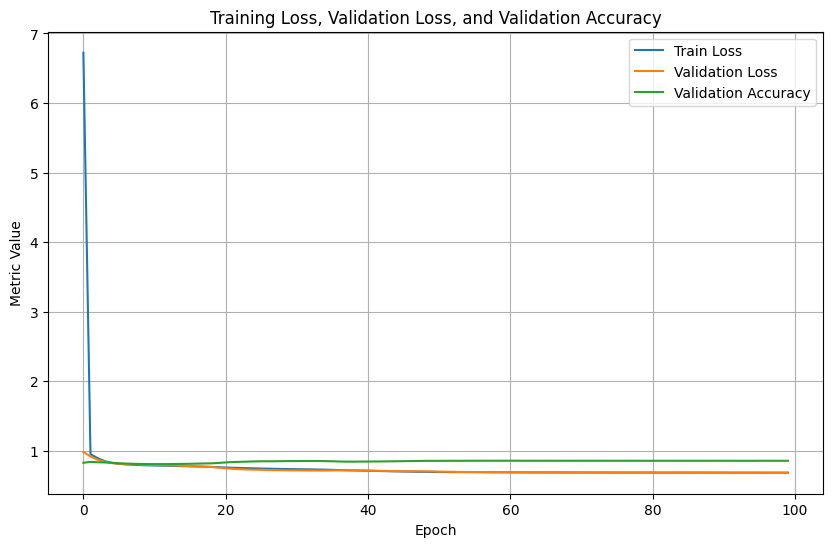

In [ ]:
 
# Plotting the metrics
epochs = range(len(train_losses))
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Metric Value')
plt.title('Training Loss, Validation Loss, and Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()
